# ModVege grass growth model (Jouven et al. 2006) with HiResIreland data

- Jouven, M., Carrère, P., and Baumont, R. (2006a). 'Model predicting
  dynamics of biomass, structure and digestibility of herbage in managed
  permanent pastures. 1. Model description', *Grass and Forage Science*,
  vol. 61, no. 2, pp. 112-124. DOI:
  [10.1111/j.1365-2494.2006.00515.x][Jouven1].
- Jouven, M., Carrère, P., and Baumont, R. (2006b). 'Model predicting
  dynamics of biomass, structure and digestibility of herbage in managed
  permanent pastures. 2. Model evaluation', *Grass and Forage Science*,
  vol. 61, no. 2, pp. 125-133. DOI:
  [10.1111/j.1365-2494.2006.00517.x][Jouven2].
- Chemin, Y. (2022). 'modvege', Python. [Online]. Available at
  <https://github.com/YannChemin/modvege> (Accessed 6 September 2022).

[Jouven1]: https://doi.org/10.1111/j.1365-2494.2006.00515.x
[Jouven2]: https://doi.org/10.1111/j.1365-2494.2006.00517.x

In [1]:
import os
import glob
from datetime import datetime, timezone
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client
import climag.plot_configs as cplt

In [2]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-02-18 22:32:03.907517+00:00


In [ ]:
client = Client(n_workers=2, threads_per_worker=4, memory_limit="3GB")

In [ ]:
client

In [3]:
DATA_DIR = os.path.join("data", "ModVege")

In [4]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries.gpkg")
# ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE")
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE_BBOX_DIFF")

In [5]:
# met station coords
LON_VAL, LAT_VAL = -10.24333, 51.93806  # Valentia Observatory
LON_ROC, LAT_ROC = -8.24444, 51.79306  # Roche's Point
LON_JOH, LAT_JOH = -6.5, 52.29167  # Johnstown Castle
LON_MUL, LAT_MUL = -7.36222, 53.53722  # Mullingar

## rcp45

In [18]:
data = xr.open_mfdataset(
    glob.glob(
        os.path.join(
            DATA_DIR, "HiResIreland", "rcp45", "EC-EARTH", "*.nc"
        )
    ),
    chunks="auto",
    decode_coords="all"
)

In [7]:
data

<xarray.Dataset>
Dimensions:       (time: 10957, rlat: 113, rlon: 85, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 2041-01-01T10:30:00 ... 2070-12-31T10...
    lon           (rlat, rlon) float32 dask.array<chunksize=(113, 85), meta=np.ndarray>
    lat           (rlat, rlon) float32 dask.array<chunksize=(113, 85), meta=np.ndarray>
  * rlon          (rlon) float64 -1.54 -1.505 -1.47 -1.435 ... 1.33 1.365 1.4
  * rlat          (rlat) float64 -1.945 -1.91 -1.875 -1.84 ... 1.905 1.94 1.975
    height_2m     float32 2.0
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    rotated_pole  int32 0
    spatial_ref   int64 0
Dimensions without coordinates: bnds
Data variables: (12/14)
    bm_gv         (time, rlat, rlon) float32 dask.array<chunksize=(365, 113, 85), meta=np.ndarray>
    bm_gr         (time, rlat, rlon) float32 dask.array<chunksize=(365, 113, 85), meta=np.ndarray>
    bm_dv         (time, rlat, rlon) float32 dask.array<chunksize=(365, 113, 85), meta=np.ndarray>
    bm_dr         (time, rlat, rlon) float32 dask.array<chunksize=(365, 113, 85), meta=np.ndarray>
    bm            (time, rlat, rlon) float32 dask.array<chunksize=(365, 113, 85), meta=np.ndarray>
    pgro          (time, rlat, rlon) float32 dask.array<chunksize=(365, 113, 85), meta=np.ndarray>
    ...            ...
    h_bm          (time, rlat, rlon) float32 dask.array<chunksize=(365, 113, 85), meta=np.ndarray>
    env           (time, rlat, rlon) float32 dask.array<chunksize=(365, 113, 85), meta=np.ndarray>
    rep           (time, rlat, rlon) float32 dask.array<chunksize=(365, 113, 85), meta=np.ndarray>
    lai           (time, rlat, rlon) float32 dask.array<chunksize=(365, 113, 85), meta=np.ndarray>
    aet           (time, rlat, rlon) float32 dask.array<chunksize=(365, 113, 85), meta=np.ndarray>
    wr            (time, rlat, rlon) float32 dask.array<chunksize=(365, 113, 85), meta=np.ndarray>
Attributes:
    creation_date:  2023-02-10 19:58:44.032666+00:00
    contact:        nstreethran@ucc.ie
    frequency:      day
    references:     https://github.com/ClimAg

In [8]:
# remove the spin-up year
data = data.sel(time=slice("2042", "2070"))

### Seasonal averages

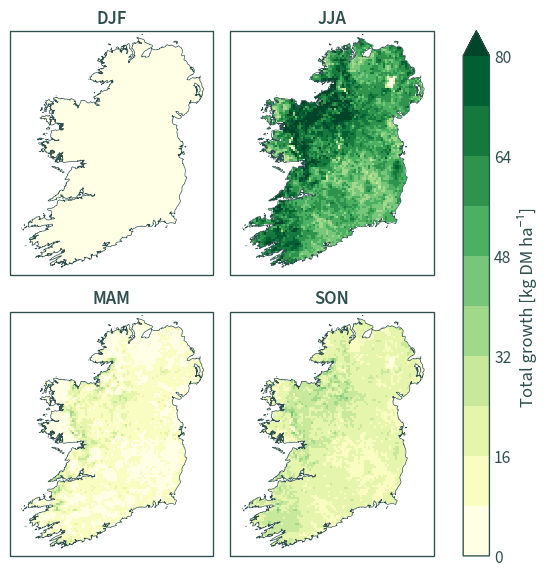

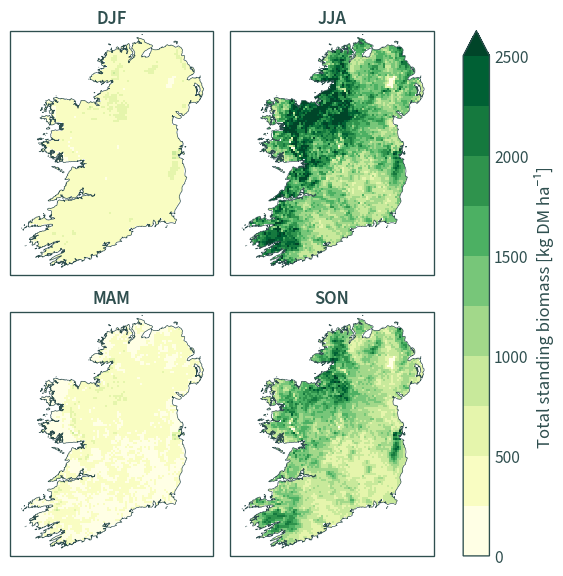

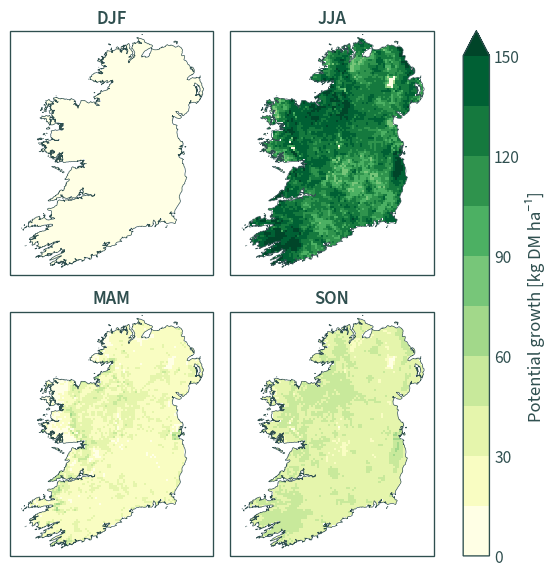

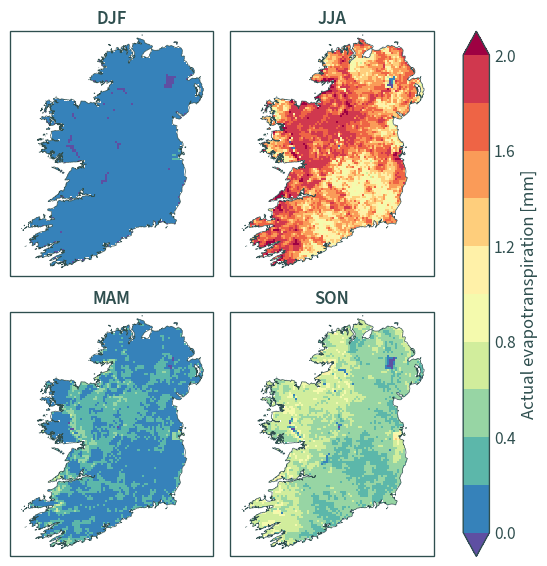

In [12]:
for var in ["gro", "bm", "pgro", "aet"]:
    cplt.plot_averages(
        data=data, var=var, averages="season", boundary_data=ie,
        cbar_levels=12
    )

### Point subset

#### Valentia Observatory

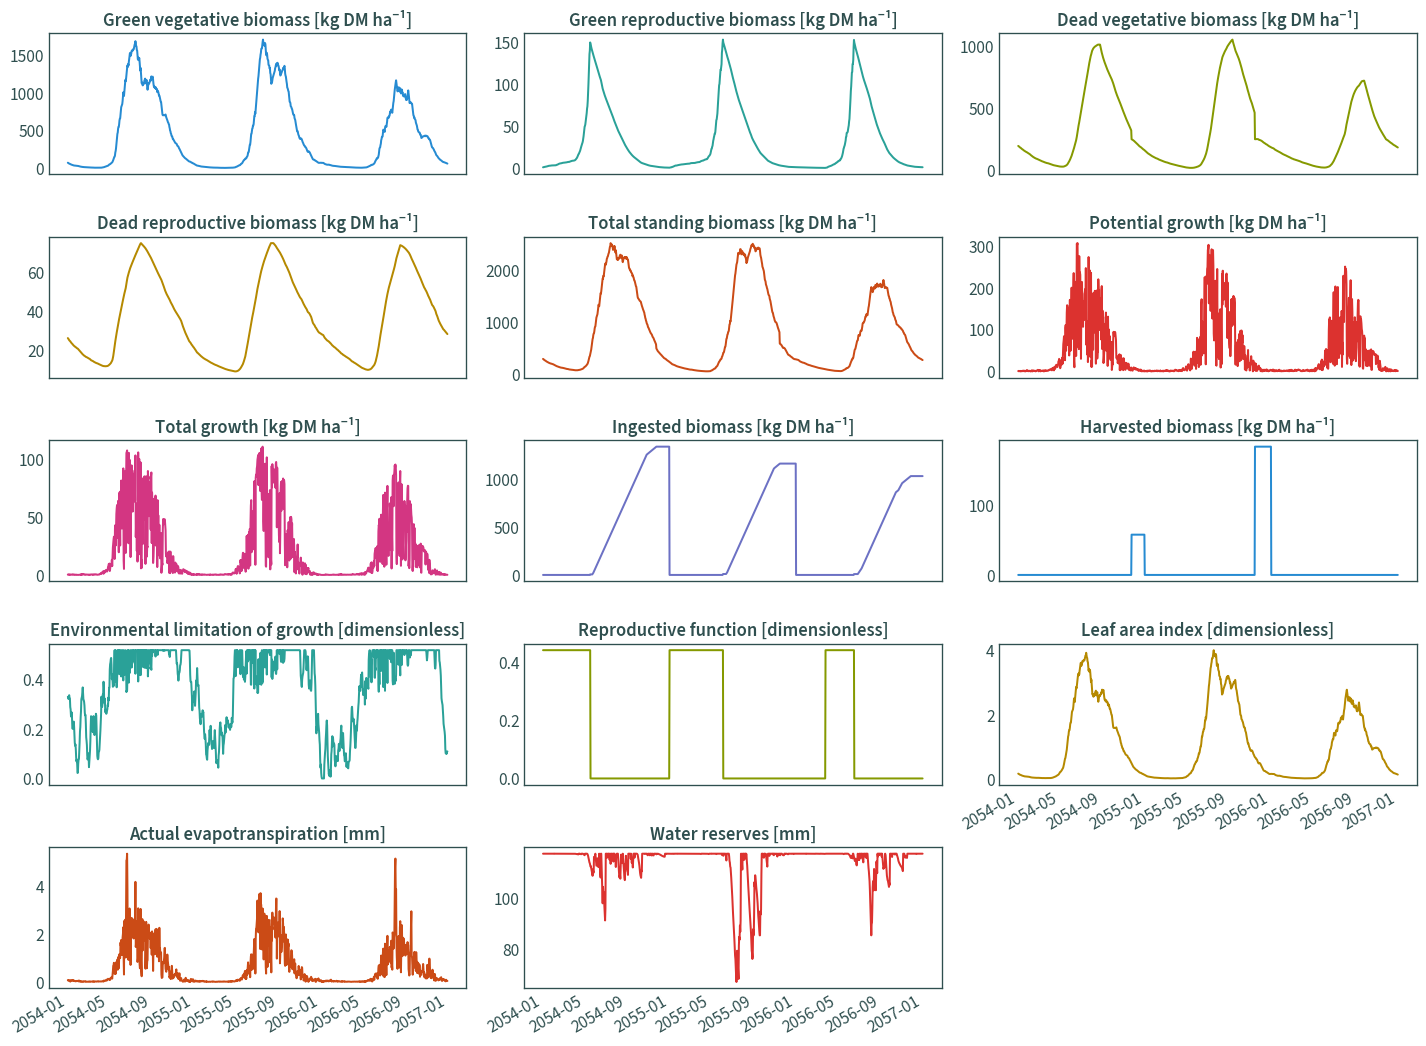

In [14]:
cds = cplt.rotated_pole_point(data=data, lon=LON_VAL, lat=LAT_VAL)
data_ie = data.sel(
    {"rlon": cds[0], "rlat": cds[1]}, method="nearest"
).sel(time=slice("2054", "2056"))

data_ie_df = pd.DataFrame({"time": data_ie["time"]})
for var in data_ie.data_vars:
    data_ie_df[var] = data_ie[var]

data_ie_df.set_index("time", inplace=True)

# configure plot title
plot_title = []
for var in data_ie.data_vars:
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.plot(
    subplots=True, layout=(5, 3), figsize=(15, 11),
    legend=False, xlabel="", title=plot_title
)

plt.tight_layout()
plt.show()

#### Roche's Point

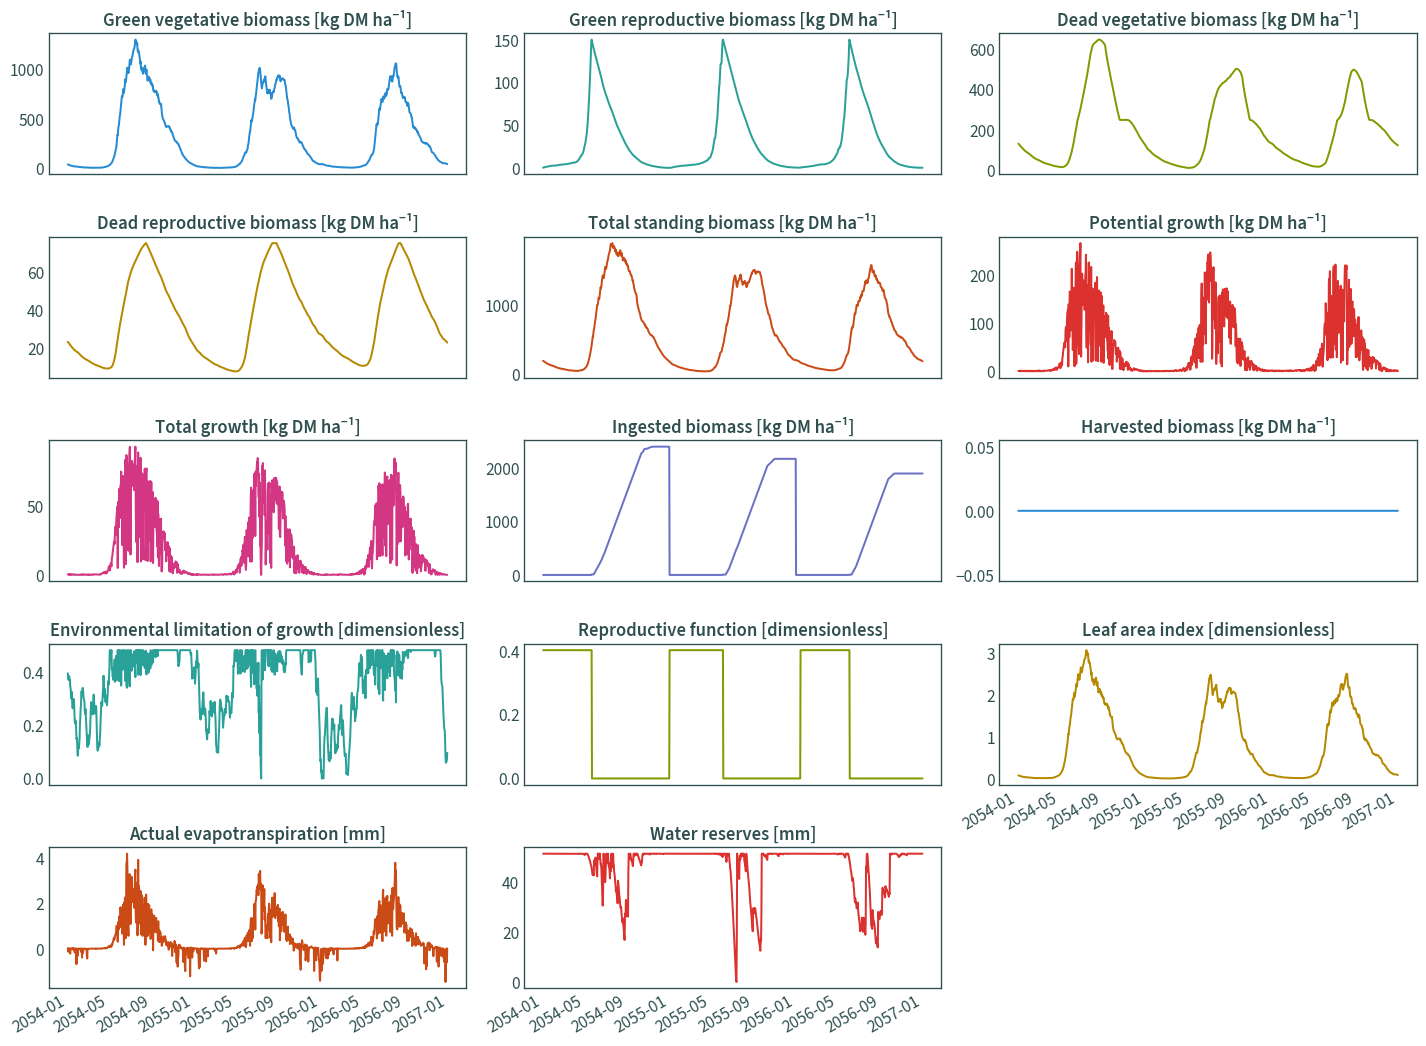

In [15]:
cds = cplt.rotated_pole_point(data=data, lon=LON_ROC, lat=LAT_ROC)
data_ie = data.sel(
    {"rlon": cds[0], "rlat": cds[1]}, method="nearest"
).sel(time=slice("2054", "2056"))

data_ie_df = pd.DataFrame({"time": data_ie["time"]})
for var in data_ie.data_vars:
    data_ie_df[var] = data_ie[var]

data_ie_df.set_index("time", inplace=True)

# configure plot title
plot_title = []
for var in data_ie.data_vars:
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.plot(
    subplots=True, layout=(5, 3), figsize=(15, 11),
    legend=False, xlabel="", title=plot_title
)

plt.tight_layout()
plt.show()

#### Johnstown Castle

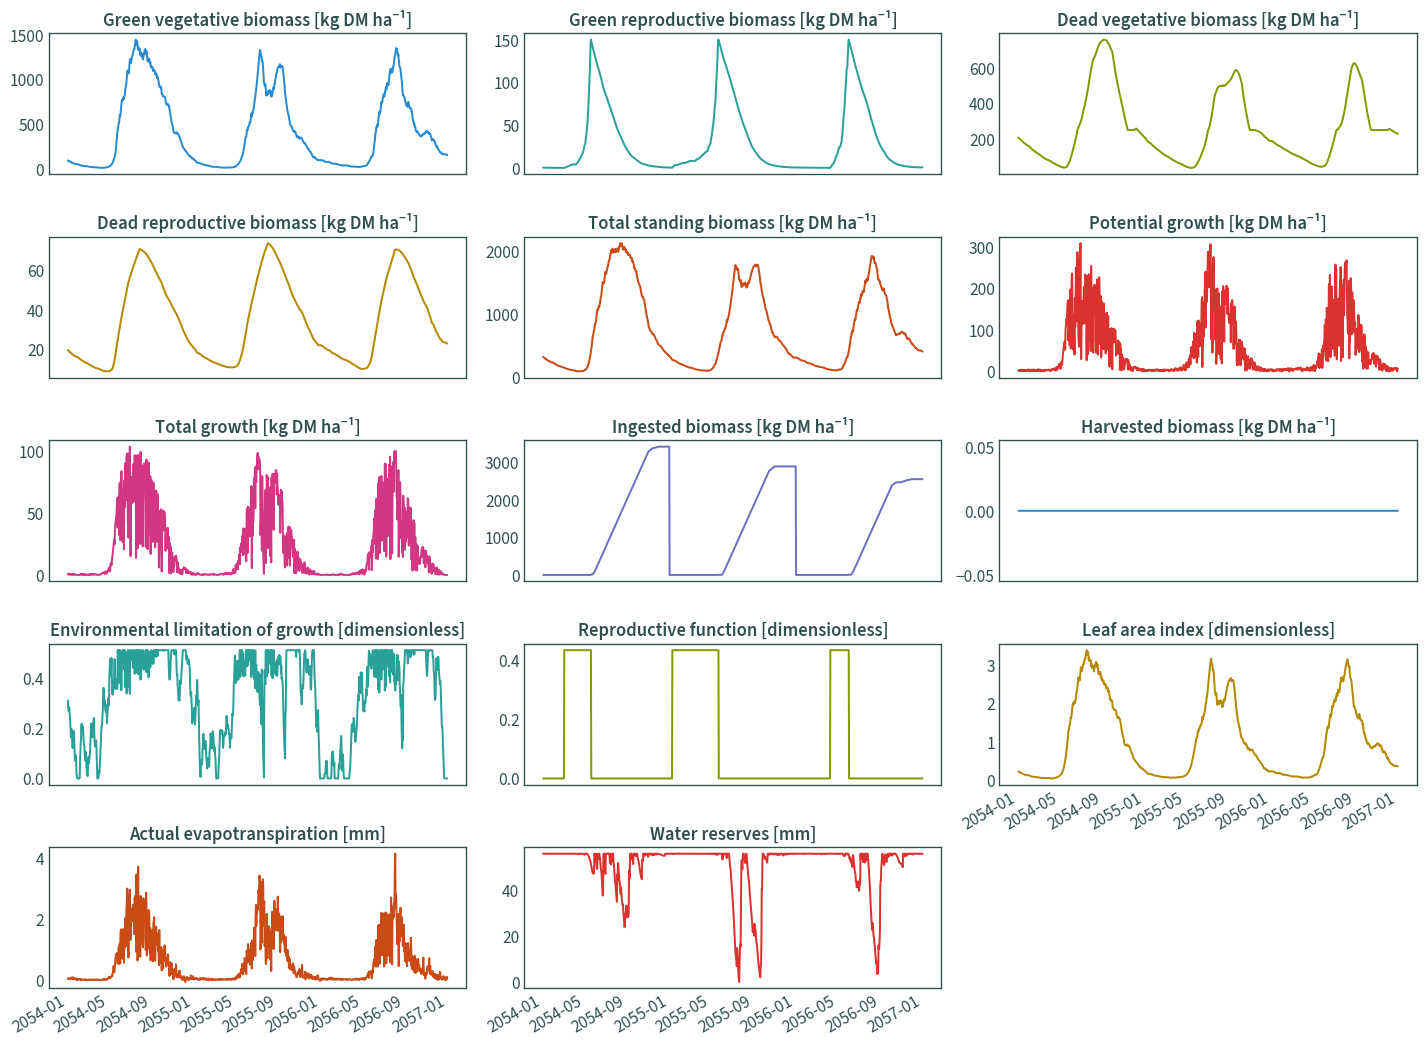

In [16]:
cds = cplt.rotated_pole_point(data=data, lon=LON_JOH, lat=LAT_JOH)
data_ie = data.sel(
    {"rlon": cds[0], "rlat": cds[1]}, method="nearest"
).sel(time=slice("2054", "2056"))

data_ie_df = pd.DataFrame({"time": data_ie["time"]})
for var in data_ie.data_vars:
    data_ie_df[var] = data_ie[var]

data_ie_df.set_index("time", inplace=True)

# configure plot title
plot_title = []
for var in data_ie.data_vars:
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.plot(
    subplots=True, layout=(5, 3), figsize=(15, 11),
    legend=False, xlabel="", title=plot_title
)

plt.tight_layout()
plt.show()

#### Mullingar

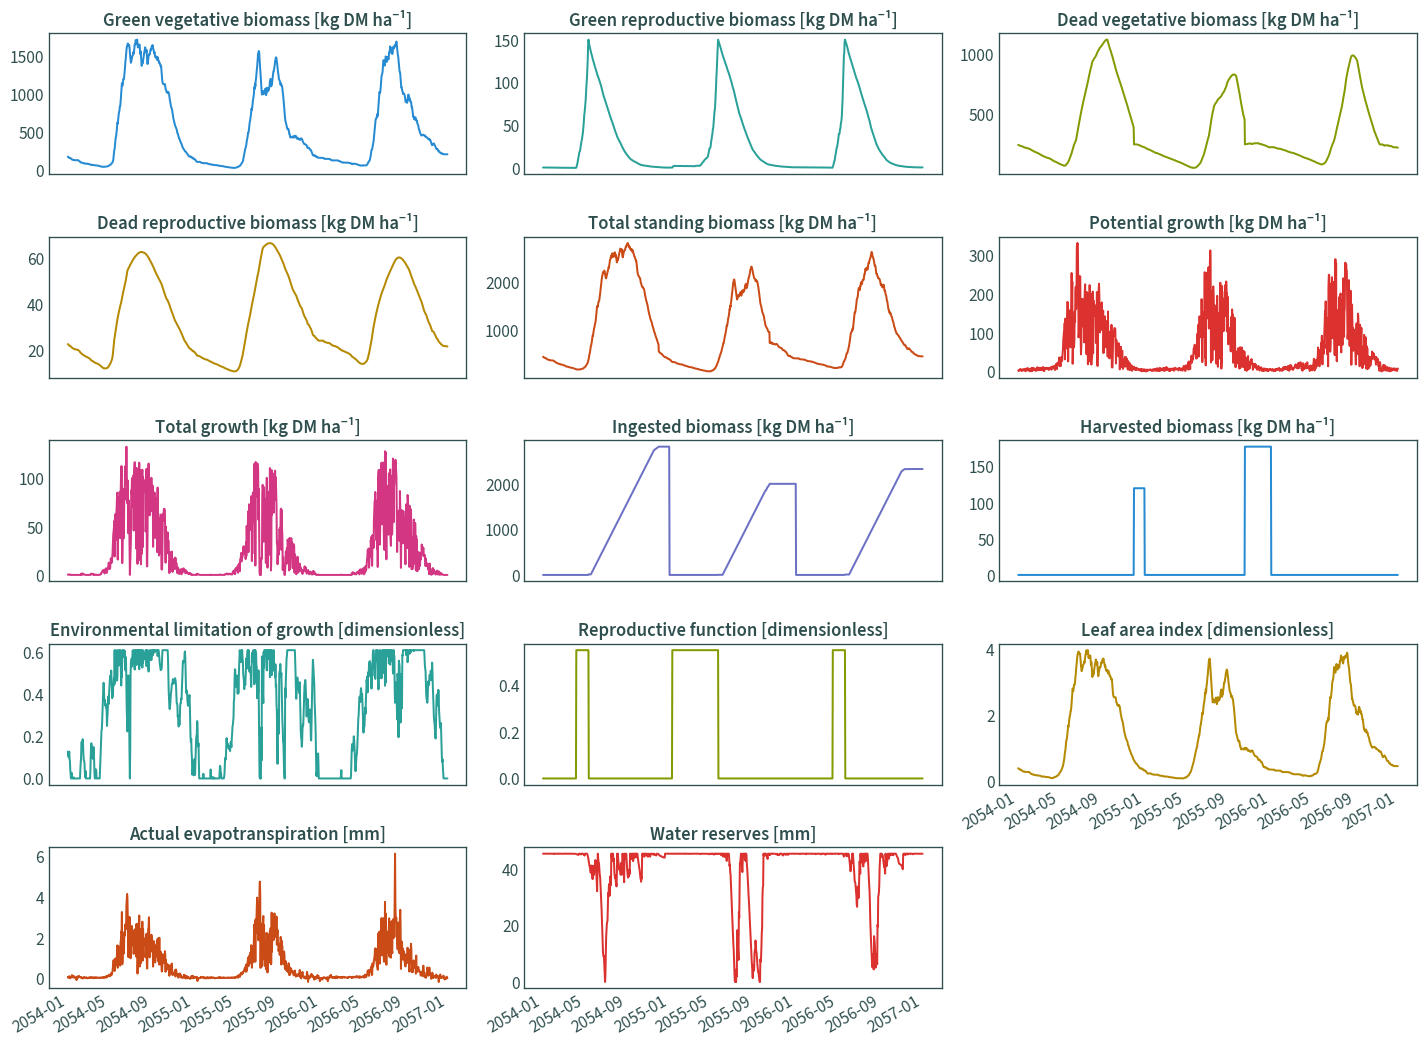

In [17]:
cds = cplt.rotated_pole_point(data=data, lon=LON_MUL, lat=LAT_MUL)
data_ie = data.sel(
    {"rlon": cds[0], "rlat": cds[1]}, method="nearest"
).sel(time=slice("2054", "2056"))

data_ie_df = pd.DataFrame({"time": data_ie["time"]})
for var in data_ie.data_vars:
    data_ie_df[var] = data_ie[var]

data_ie_df.set_index("time", inplace=True)

# configure plot title
plot_title = []
for var in data_ie.data_vars:
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.plot(
    subplots=True, layout=(5, 3), figsize=(15, 11),
    legend=False, xlabel="", title=plot_title
)

plt.tight_layout()
plt.show()